In [1]:
from data import load_data, data_prep
from train import train, objective, build_hidden_mults
from data_openml import DataSetCatCon
from torch.utils.data import DataLoader
from models import SAINT
import torch.optim as optim
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostRegressor
import pandas as pd
import optuna
import numpy as np
import torch
from optuna.exceptions import TrialPruned
import os
import pickle

##################################
MAX_FEATURES=100  
N_TRIALS= 10     
N_ROWS = None    # Set to None to use all rows
BS = 32
##################################

X, y = load_data(n_rows=N_ROWS)

#========> Set a random seed for reproducibility
np.random.seed(239048)
cat_dims, cat_idxs, con_idxs, X_train, y_train, X_valid, y_valid, X_test, y_test, train_mean, train_std, continuous_mean_std = data_prep(X, y, datasplit=[.65, .15, .2])


In [2]:
# check if the following file exists.
filename = f"fgps_selector-{MAX_FEATURES}.pkl"
if os.path.exists(filename):
    with open(filename, "rb") as f:
        fgpts_selector = pickle.load(f)
else:
    # select best fingerprints 
    X_catboost = pd.DataFrame(X_train["data"])
    categorical_columns = [X_catboost.columns[i] for i in cat_idxs]
    for col in categorical_columns:
        X_catboost[col] = X_catboost[col].astype("int")
    model2 = CatBoostRegressor(cat_features=cat_idxs) 
    #================> should use only train data to avoid data leakage
    model2.fit(X_catboost, y_train["data"])
    #==================> To only select based on max_features, set threshold=-np.inf.
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
    fgpts_selector = SelectFromModel(model2, prefit=True, threshold=-np.inf, max_features=MAX_FEATURES)
    with open(filename, "wb") as f:
        pickle.dump(fgpts_selector, f)


In [3]:
features_mask = fgpts_selector.get_support()
# Force that both m/z and adduct are always selected 
features_mask[0] = True
features_mask[1] = True
# Ensure m/z is always selected
assert features_mask[0] == True
# Ensure adduct is always selected
assert features_mask[1] == True

n_features = X_train["data"][:, features_mask].shape[1]

cat_idxs = list(range(1, n_features))
print(cat_idxs)
cat_dims = cat_dims[:n_features]
print(cat_dims)

X_train["data"] = X_train["data"][:, features_mask]
X_train["mask"] = X_train["mask"][:, features_mask]
X_valid["data"] = X_valid["data"][:, features_mask]
X_valid["mask"] = X_valid["mask"][:, features_mask]
X_test["data"] = X_test["data"][:, features_mask]
X_test["mask"] = X_test["mask"][:, features_mask]



[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 3 2 2 2 2 2 2 2 2]


In [4]:
train_ds = DataSetCatCon(X_train, y_train, cat_idxs,'reg',continuous_mean_std)
trainloader = DataLoader(train_ds, batch_size=BS, shuffle=True,num_workers=4)

valid_ds = DataSetCatCon(X_valid, y_valid, cat_idxs,'reg', continuous_mean_std)
validloader = DataLoader(valid_ds, batch_size=BS, shuffle=False,num_workers=4)

test_ds = DataSetCatCon(X_test, y_test, cat_idxs,'reg', continuous_mean_std)
testloader = DataLoader(test_ds, batch_size=BS, shuffle=False,num_workers=4)

In [5]:
# select best hyperparameters

storage_name = "sqlite:///saint.db"
study1 = optuna.create_study(study_name=f"MF_{MAX_FEATURES}_step-1", storage=storage_name, load_if_exists=True)

study1.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, first_trial=True), n_trials=N_TRIALS, catch=(Exception, ))
optim_params1 = study1.best_params 

lr = optim_params1['lr']
wd = optim_params1['weight_decay']
epochs = optim_params1['epochs']

[I 2024-06-26 12:18:07,917] A new study created in RDB with name: MF_10_step-1


lr: 0.0016262814661355933, weight_decay: 0.03836305060931314, epochs: 3, dim: 32, depth: 1, heads: 4, attn_dropout: 0.8, ff_dropout: 0.8, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


100%|██████████| 3/3 [00:49<00:00, 16.54s/it]
[I 2024-06-26 12:18:58,621] Trial 0 finished with value: 17.785057067871094 and parameters: {'lr': 0.0016262814661355933, 'weight_decay': 0.03836305060931314, 'epochs': 3}. Best is trial 0 with value: 17.785057067871094.


lr: 0.0009032950604808624, weight_decay: 0.09536171206248002, epochs: 1, dim: 32, depth: 1, heads: 4, attn_dropout: 0.8, ff_dropout: 0.8, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


100%|██████████| 1/1 [00:14<00:00, 14.13s/it]
[I 2024-06-26 12:19:12,927] Trial 1 finished with value: 16.720035552978516 and parameters: {'lr': 0.0009032950604808624, 'weight_decay': 0.09536171206248002, 'epochs': 1}. Best is trial 1 with value: 16.720035552978516.


lr: 0.0003197395932077835, weight_decay: 0.049817136350757775, epochs: 1, dim: 32, depth: 1, heads: 4, attn_dropout: 0.8, ff_dropout: 0.8, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


100%|██████████| 1/1 [00:13<00:00, 13.75s/it]
[I 2024-06-26 12:19:26,780] Trial 2 finished with value: 16.664581298828125 and parameters: {'lr': 0.0003197395932077835, 'weight_decay': 0.049817136350757775, 'epochs': 1}. Best is trial 2 with value: 16.664581298828125.


In [9]:
# Create an unique id for step-2 based on the best hyperparameters from step-1
# unique_id = hash("{}-{}".format(str(lr), str(wd), str(epochs)))

unique_id = hash("{}-{}-{}".format(str(lr), str(wd), str(epochs)))
study = optuna.create_study(
    study_name=f"MF_{MAX_FEATURES}_id_{unique_id}_step-2",
    storage=storage_name,
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=10, reduction_factor=3
    ),
    load_if_exists=True
)

study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))


[I 2024-06-26 12:21:52,642] Using an existing study with name 'MF_10_id_-2913089468112480739_step-2' instead of creating a new one.


lr: 0.0003197395932077835, weight_decay: 0.049817136350757775, epochs: 10, dim: 31, depth: 1, heads: 5, attn_dropout: 0.8015093591867534, ff_dropout: 0.5041127359758025, mlp_hidden_mults: (8, 4), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


100%|██████████| 10/10 [02:41<00:00, 16.14s/it]
[I 2024-06-26 12:24:34,178] Trial 1 finished with value: 17.169990158081056 and parameters: {'dim': 31, 'depth': 1, 'heads': 5, 'attn_dropout': 0.8015093591867534, 'ff_dropout': 0.5041127359758025, 'mlp_hidden_mults': 8, 'final_mlp_style': 'common'}. Best is trial 1 with value: 17.169990158081056.


lr: 0.0003197395932077835, weight_decay: 0.049817136350757775, epochs: 10, dim: 16, depth: 1, heads: 5, attn_dropout: 0.8395134754519894, ff_dropout: 0.5729331729379622, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


 10%|█         | 1/10 [00:30<04:31, 30.14s/it]
[I 2024-06-26 12:25:04,564] Trial 2 pruned. 


lr: 0.0003197395932077835, weight_decay: 0.049817136350757775, epochs: 10, dim: 58, depth: 2, heads: 8, attn_dropout: 0.5160325451330369, ff_dropout: 0.5870732184123607, mlp_hidden_mults: (16, 8), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


100%|██████████| 10/10 [04:31<00:00, 27.10s/it]
[I 2024-06-26 12:29:35,981] Trial 3 finished with value: 16.98213710784912 and parameters: {'dim': 58, 'depth': 2, 'heads': 8, 'attn_dropout': 0.5160325451330369, 'ff_dropout': 0.5870732184123607, 'mlp_hidden_mults': 16, 'final_mlp_style': 'sep'}. Best is trial 3 with value: 16.98213710784912.


lr: 0.0003197395932077835, weight_decay: 0.049817136350757775, epochs: 10, dim: 33, depth: 2, heads: 7, attn_dropout: 0.1644763179605259, ff_dropout: 0.5228157650105396, mlp_hidden_mults: (16, 8), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


 10%|█         | 1/10 [00:41<06:10, 41.14s/it]
[I 2024-06-26 12:30:17,362] Trial 4 pruned. 


lr: 0.0003197395932077835, weight_decay: 0.049817136350757775, epochs: 10, dim: 54, depth: 3, heads: 8, attn_dropout: 0.6353821240135431, ff_dropout: 0.534699356058616, mlp_hidden_mults: (16, 8), final_mlp_style: common, optimizer: AdamW, scheduler: cosine
Using device = cuda:0


  0%|          | 0/10 [00:16<?, ?it/s]
[W 2024-06-26 12:30:34,357] Trial 5 failed with parameters: {'dim': 54, 'depth': 3, 'heads': 8, 'attn_dropout': 0.6353821240135431, 'ff_dropout': 0.534699356058616, 'mlp_hidden_mults': 16, 'final_mlp_style': 'common'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/gaussllego/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_32122/647068542.py", line 19, in <lambda>
    study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(Exception, ))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gaussllego/code/tfg_ccsPrediction/train.py", line 141, in objective
    valid_rmse = train(model, opt

KeyboardInterrupt: 

---------> cuda:0


100%|██████████| 1/1 [00:37<00:00, 37.80s/it]


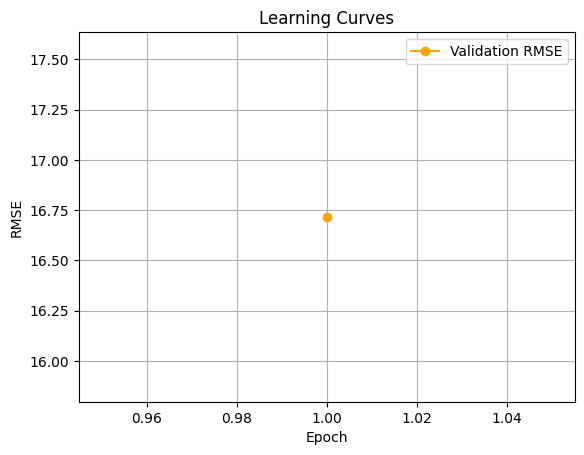

16.716421127319336


In [12]:
optim_params = study.best_params 
optim_params['mlp_hidden_mults'] = build_hidden_mults(optim_params['mlp_hidden_mults'])  

model = SAINT(
    categories = tuple(cat_dims), 
    num_continuous = len(con_idxs),                
    dim = optim_params['dim'],                         
    dim_out = 1,                       
    depth = optim_params['depth'],                        
    heads = optim_params['heads'],                         
    attn_dropout = optim_params['attn_dropout'],             
    ff_dropout = optim_params['ff_dropout'],                  
    mlp_hidden_mults = optim_params['mlp_hidden_mults'],       
    cont_embeddings = 'MLP',
    attentiontype = 'colrow',
    final_mlp_style = optim_params['final_mlp_style'],
    y_dim = 1 # porque es regression 
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device = {device}")
model.to(device)

# ========> we always use the following
optimizer = optim.AdamW(model.parameters(),lr=optim_params1['lr'], weight_decay=optim_params1['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, optim_params1['epochs'])

test_rmse = train(model, optimizer, scheduler, optim_params1["epochs"], trainloader, testloader, plot=True)
print(f"Final test RMSE: {test_rmse}")